In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import joblib

In [2]:
data = pd.read_csv("./data/mud_props_for_deployment_water.csv")

In [3]:
data

,Mud Wt. In (ppg),Funnel Viscosity,Fann 600 rpm,Fann 300 rpm
0,0.010131,0.412897,0.398015,0.367512
1,0.006612,0.320988,0.422535,0.421053
2,0.006612,0.320988,0.422535,0.421053
3,0.003306,0.506173,0.000000,0.052632
4,0.003306,0.506173,0.000000,0.052632
...,...,...,...,...
577,0.024793,0.345679,0.366197,0.315789
578,0.024793,0.333333,0.366197,0.333333
579,0.024793,0.345679,0.366197,0.333333
580,0.024793,0.345679,0.366197,0.333333


In [4]:
data.columns

Index(['Mud Wt. In (ppg)', 'Funnel Viscosity ', 'Fann 600 rpm',
       'Fann 300 rpm'],
      dtype='object')

In [5]:
X = data[['Mud Wt. In (ppg)','Funnel Viscosity ']]

y = data[['Fann 600 rpm', 'Fann 300 rpm']]

In [6]:
def create_model(units1=64, units2=256, units3=128, units4=32, dropout_rate=0.2):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X.shape[1],)),
        Dropout(dropout_rate),
        Dense(units2, activation='relu'),
        Dropout(dropout_rate),
        Dense(units3, activation='relu'),
        Dropout(dropout_rate),
        Dense(units4, activation='relu'),
        Dropout(dropout_rate),
        Dense(y.shape[1])  # Output layer
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

In [7]:
def train_and_evaluate_models(X, y, n_epochs=5):
    # Split the data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

    models = {
        'Linear Regression': Pipeline([
            ('poly', PolynomialFeatures()),
            ('linear_reg', LinearRegression())
        ]),
        'Random Forest': RandomForestRegressor(random_state=42),
        'SVR': MultiOutputRegressor(SVR()),
        'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
    }

    param_grids = {
        'Linear Regression': {'poly__degree': [1, 2, 3]},
        'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
        'SVR': {'estimator__C': [0.1, 1, 10], 'estimator__kernel': ['rbf', 'poly']},
        'Gradient Boosting': {'estimator__n_estimators': [50, 100, 200], 'estimator__learning_rate': [0.01, 0.1, 0.2]}
    }

    for name, model in models.items():
        print(f"\n{name}:")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
        
        # Evaluate on validation set
        y_val_pred = best_model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred, multioutput='raw_values'))
        val_r2 = r2_score(y_val, y_val_pred, multioutput='raw_values')
        print("Validation RMSE for each output:")
        for i, (rmse, r2) in enumerate(zip(val_rmse, val_r2)):
            print(f"  Output {i+1}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")
        
        # Evaluate on test set
        y_test_pred = best_model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
        test_r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
        print("Test RMSE for each output:")
        for i, (rmse, r2) in enumerate(zip(test_rmse, test_r2)):
            print(f"  Output {i+1}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")
        
        # Save Random Forest and Gradient Boosting models
        if name == 'Random Forest':
            joblib.dump(best_model, "random_forest_model.sav")
            print("Random Forest model saved as 'random_forest_model.sav'")
        elif name == 'Gradient Boosting':
            joblib.dump(best_model, "gradient_boosting_model.sav")
            print("Gradient Boosting model saved as 'gradient_boosting_model.sav'")

    # CNN model
    print("\nCNN (Deep Learning):")
    
    # Define the model using KerasRegressor
    cnn_model = KerasRegressor(model=create_model, epochs=20, batch_size=32, verbose=0)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'model__units1': [32, 64],
        'model__units2': [128, 256],
        'model__units3': [64, 128],
        'model__units4': [16, 32],
        'model__dropout_rate': [0.1, 0.2]
    }
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=cnn_model, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred, multioutput='raw_values'))
    val_r2 = r2_score(y_val, y_val_pred, multioutput='raw_values')
    print("Validation RMSE for each output:")
    for i, (rmse, r2) in enumerate(zip(val_rmse, val_r2)):
        print(f"  Output {i+1}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

    # Evaluate on test set
    y_test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
    test_r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
    print("Test RMSE for each output:")
    for i, (rmse, r2) in enumerate(zip(test_rmse, test_r2)):
        print(f"  Output {i+1}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

In [8]:
train_and_evaluate_models(X, y)


Linear Regression:


Best parameters: {'poly__degree': 1}
Validation RMSE for each output:
  Output 1: RMSE = 0.1343, R^2 = 0.3620
  Output 2: RMSE = 0.1308, R^2 = 0.4154
Test RMSE for each output:
  Output 1: RMSE = 0.1358, R^2 = 0.1825
  Output 2: RMSE = 0.1231, R^2 = 0.2893

Random Forest:
Best parameters: {'max_depth': 20, 'n_estimators': 200}
Validation RMSE for each output:
  Output 1: RMSE = 0.0969, R^2 = 0.6677
  Output 2: RMSE = 0.0888, R^2 = 0.7309
Test RMSE for each output:
  Output 1: RMSE = 0.0829, R^2 = 0.6955
  Output 2: RMSE = 0.0806, R^2 = 0.6955
Random Forest model saved as 'random_forest_model.sav'

SVR:
Best parameters: {'estimator__C': 1, 'estimator__kernel': 'rbf'}
Validation RMSE for each output:
  Output 1: RMSE = 0.1343, R^2 = 0.3624
  Output 2: RMSE = 0.1309, R^2 = 0.4149
Test RMSE for each output:
  Output 1: RMSE = 0.1329, R^2 = 0.2171
  Output 2: RMSE = 0.1226, R^2 = 0.2948

Gradient Boosting:
Best parameters: {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 200}
Va

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters: {'model__dropout_rate': 0.1, 'model__units1': 32, 'model__units2': 128, 'model__units3': 64, 'model__units4': 32}
Validation RMSE for each output:
  Output 1: RMSE = 0.1378, R^2 = 0.3285
  Output 2: RMSE = 0.1335, R^2 = 0.3912
Test RMSE for each output:
  Output 1: RMSE = 0.1355, R^2 = 0.1870
  Output 2: RMSE = 0.1230, R^2 = 0.2898


2024/09/19 04:38:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving single objective optimization problem.
2024/09/19 04:38:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 0.00901826149416566, Global best: 0.00901826149416566, Runtime: 0.11637 seconds
2024/09/19 04:38:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 0.00901826149416566, Global best: 0.00901826149416566, Runtime: 0.11854 seconds
2024/09/19 04:38:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 0.00901826149416566, Global best: 0.00901826149416566, Runtime: 0.12328 seconds
2024/09/19 04:38:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 0.009017202620698973, Global best: 0.009017202620698973, Runtime: 0.11569 seconds
2024/09/19 04:38:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 0.00901083299696383, Global best: 0.00901083299696383, Runtime: 

Best Parameters from GWO: max_depth=9, min_samples_split=2, min_samples_leaf=2
Validation RMSE for each output:
  Output 1: RMSE = 0.0995, R^2 = 0.6499
  Output 2: RMSE = 0.0901, R^2 = 0.7227
Test RMSE for each output:
  Output 1: RMSE = 0.1066, R^2 = 0.4967
  Output 2: RMSE = 0.1045, R^2 = 0.4872


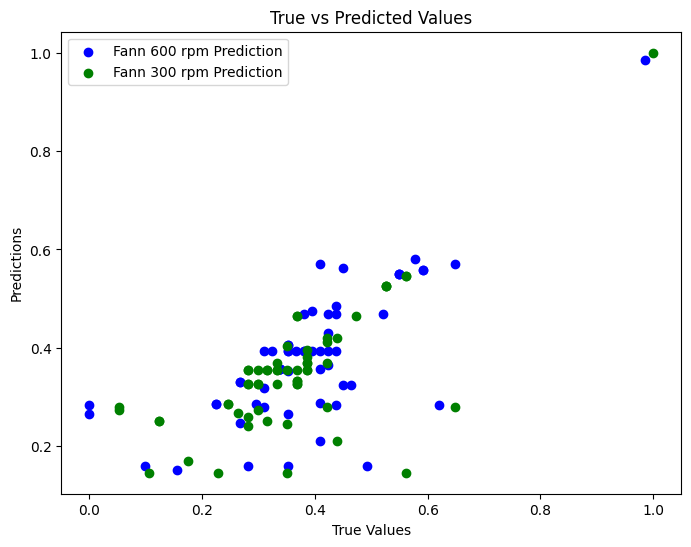

['gwo_decision_tree_regressor.sav']

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from mealpy import FloatVar, GWO
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Train-validation-test split
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Define objective function for GWO
def objective_function(solution):
    max_depth, min_samples_split, min_samples_leaf = solution

    # Convert hyperparameters to integers
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    # Train DecisionTreeRegressor with current hyperparameters
    regressor = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    regressor.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = regressor.predict(X_val)
    
    # Use Mean Squared Error (MSE) as the fitness measure
    mse = mean_squared_error(y_val, y_val_pred)
    
    return mse  # Return MSE (GWO minimizes the objective function)

# Define the bounds and the problem for GWO
problem_dict = {
    "bounds": FloatVar(lb=(1, 2, 1), ub=(50, 20, 20), name="hyperparameters"),  # Bounds for max_depth, min_samples_split, min_samples_leaf
    "minmax": "min",
    "obj_func": objective_function
}

# Apply Grey Wolf Optimization (GWO)
model = GWO.GWO_WOA(epoch=20, pop_size=20)  # Example hyperparameters for GWO
g_best = model.solve(problem_dict)

# Best hyperparameters found by GWO
best_max_depth, best_min_samples_split, best_min_samples_leaf = map(int, g_best.solution)
print(f"Best Parameters from GWO: max_depth={best_max_depth}, min_samples_split={best_min_samples_split}, min_samples_leaf={best_min_samples_leaf}")

# Train the final DecisionTreeRegressor with the optimized hyperparameters
best_model = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf)
best_model.fit(X_train, y_train)

# --- Validation Metrics ---
y_val_pred = best_model.predict(X_val)

# Compute RMSE and R^2 for each output
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred, multioutput='raw_values'))
val_r2 = r2_score(y_val, y_val_pred, multioutput='raw_values')

print("Validation RMSE for each output:")
for i, (rmse, r2) in enumerate(zip(val_rmse, val_r2)):
    print(f"  Output {i+1}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# --- Test Metrics ---
y_test_pred = best_model.predict(X_test)

# Compute RMSE and R^2 for each output
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
test_r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')

print("Test RMSE for each output:")
for i, (rmse, r2) in enumerate(zip(test_rmse, test_r2)):
    print(f"  Output {i+1}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# Visualize the performance with scatter plots
plt.figure(figsize=(8, 6))
plt.scatter(y_test['Fann 600 rpm'], y_test_pred[:, 0], label='Fann 600 rpm Prediction', color='blue')
plt.scatter(y_test['Fann 300 rpm'], y_test_pred[:, 1], label='Fann 300 rpm Prediction', color='green')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# Save the final model
joblib.dump(best_model, 'gwo_decision_tree_regressor.sav')
